In [ ]:
import numpy as np
from tabpfn import TabPFNRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, 
                                           ExpSineSquared, ConstantKernel)
from matplotlib import pyplot as plt

In [ ]:
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['axes.titlepad'] = 12
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 25
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [7.8, 5.8]
rcParams['figure.titlesize'] = 25
rcParams['font.size'] = 20.0
rcParams['legend.fontsize'] = 20
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17

## How TabPFN extrapolate in 2D?

In [3]:
def linear(x):
    return x.sum(1)

def quadratic(x):
    return np.sum(x**2, 1)

def step(x):
    return np.array([-1 if x[i,0]<0 and x[i,1]<0 else 1 for i in range(x.shape[0])])


np.random.seed(20250419)
grid_values = np.random.uniform(-1, 1, size=(4, 4))
def bilinear_interp(x):
    """
    Piecewise bilinear interpolation on a regular grid
    
    Parameters:
    x, y : arrays - Input coordinates (must be in [0,1])
    grid_values : 2D array - Function values at grid points
    """
    x, y = x[:,0], x[:,1]
    n = grid_values.shape[0] - 1
    m = grid_values.shape[1] - 1
    
    # Find which cell each point falls into
    i = np.clip((x * n).astype(int), 0, n-1)
    j = np.clip((y * m).astype(int), 0, m-1)
    
    # Local coordinates within the cell
    x_loc = x * n - i
    y_loc = y * m - j
    
    # Bilinear interpolation formula
    return (grid_values[i,j] * (1-x_loc) * (1-y_loc) + 
            grid_values[i+1,j] * x_loc * (1-y_loc) + 
            grid_values[i,j+1] * (1-x_loc) * y_loc + 
            grid_values[i+1,j+1] * x_loc * y_loc)

/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", o

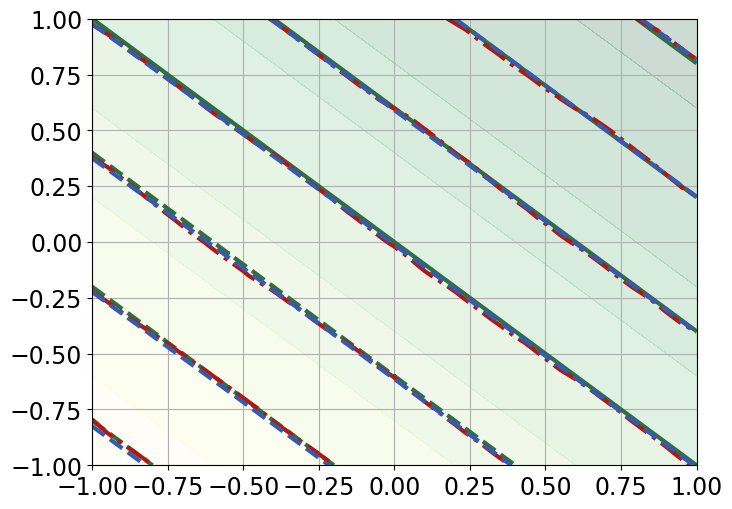

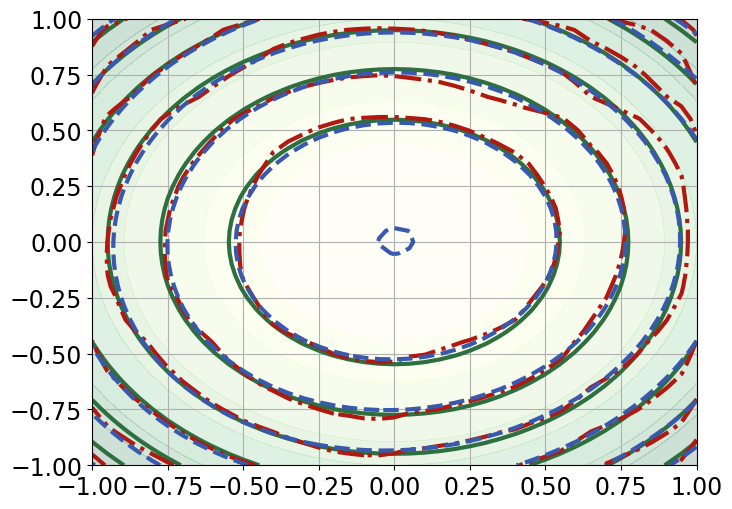

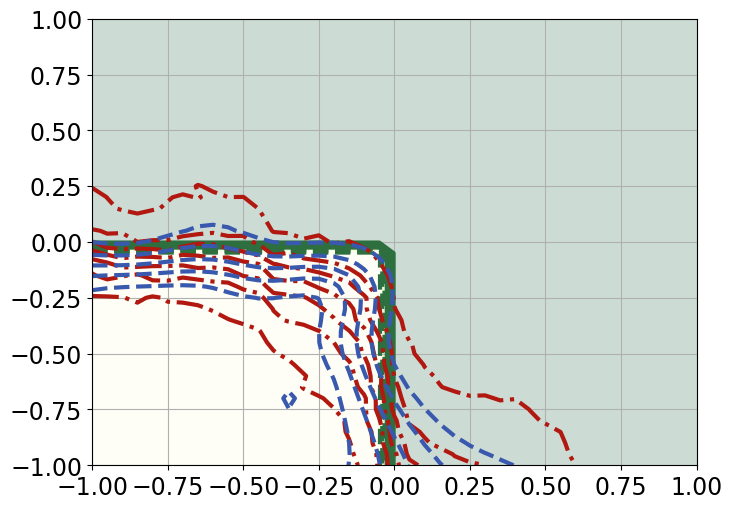

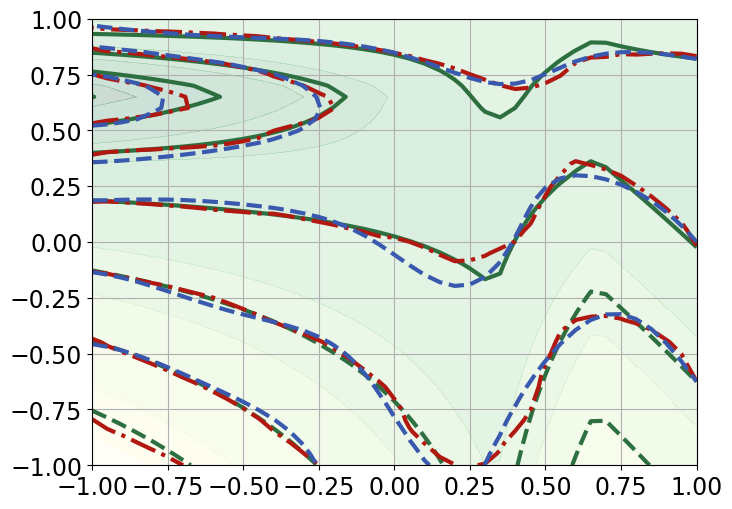

In [ ]:
fname = ["linear", "quadratic", "step", "piecewiselinear"]

# for n in [11, 31]:
for n in [11]:
    # for i, f in enumerate([linear]):
    for i, f in enumerate([linear, quadratic, step, bilinear_interp]):
        x = np.linspace(-1, 1, n)
        y = np.linspace(-1, 1, n)
        X_train_mesh, Y_train_mesh = np.meshgrid(x, y)
        X_train = np.stack([X_train_mesh.ravel(), Y_train_mesh.ravel()]).T 
        np.random.seed(1)
        X_train = X_train[np.random.choice(n**2, 7*n, replace=False)]
        epsilon = 0.05*np.random.randn(X_train.shape[0])
        y_train = f(X_train) + epsilon
    
        # TabPFN
        regressor = TabPFNRegressor(model_path = "/root/autodl-tmp/pfn/tabpfn-v2-regressor.ckpt")
        regressor.fit(X_train, y_train)
        x = np.linspace(-1, 1, 41)
        y = np.linspace(-1, 1, 41)
        X_test_mesh, Y_test_mesh = np.meshgrid(x, y)
        X_test = np.stack([X_test_mesh.ravel(), Y_test_mesh.ravel()]).T 
        y_pred = regressor.predict(X_test)
         
        # Define multiple kernel candidates
        kernel_candidates = [
            ConstantKernel() * RBF(),
            ConstantKernel() * Matern(nu=1.5),
            ConstantKernel() * RationalQuadratic(),
            ConstantKernel() * ExpSineSquared(),
            ConstantKernel() * RBF() + ConstantKernel() * Matern()
        ]
        alpha_candidates = [0.05, 0.1, 0.15, 0.2]
        
        best_score = -np.inf
        best_gpr = None

        for kernel in kernel_candidates:
            for alpha in alpha_candidates:
                gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha**2, n_restarts_optimizer=10)
                gpr.fit(X_train, y_train)
                score = gpr.log_marginal_likelihood()
                # print(alpha, score)
                
                if score > best_score:
                    best_score = score
                    best_gpr = gpr
                    best_alpha = alpha
        
        y_pred_gp, y_std_gp = gpr.predict(X_test, return_std=True)
    
        fig = plt.figure()
        # True function
        true_contour = plt.contourf(X_test_mesh, Y_test_mesh, f(X_test).reshape(X_test_mesh.shape), levels=10, cmap='YlGn', alpha=0.2)
        true_contour = plt.contour(X_test_mesh, Y_test_mesh, f(X_test).reshape(X_test_mesh.shape), levels=6,  linewidths=3, colors='#2E6F40')
        
        # TabPFN contours
        tabpfn_contour = plt.contour(X_test_mesh, Y_test_mesh, y_pred.reshape(X_test_mesh.shape), levels=6, colors="#b11810", 
                                  linestyles='-.', linewidths=3, label='TabPFN')
    
        # GP contours
        gp_contour = plt.contour(X_test_mesh, Y_test_mesh, y_pred_gp.reshape(X_test_mesh.shape), levels=6, colors="#3859ad", 
                                  linestyles='--', linewidths=3, label='GP')
        plt.grid(True)        
        plt.savefig("figure/interpolation_2d_model_" + str(fname[i]) + "_n_" + str(n) + ".png", bbox_inches='tight')

/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", o

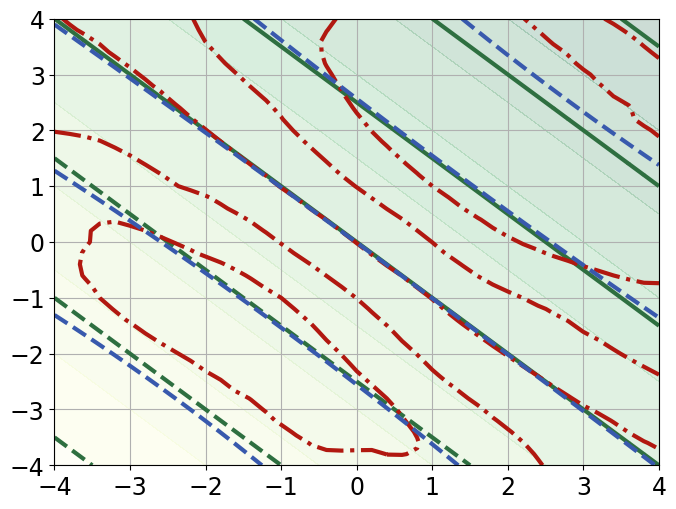

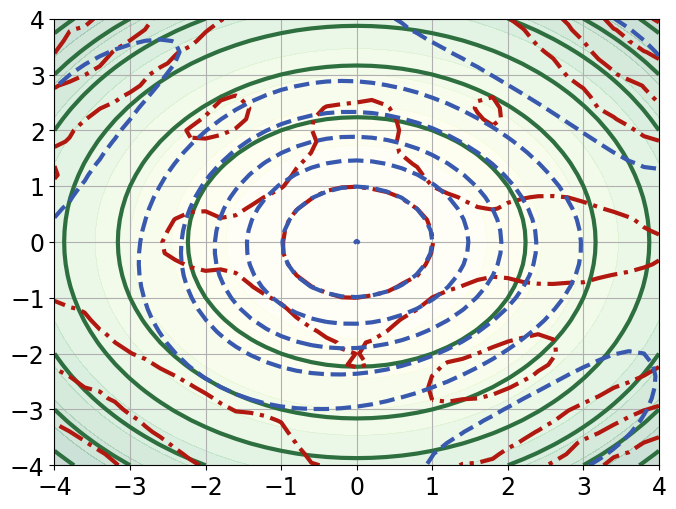

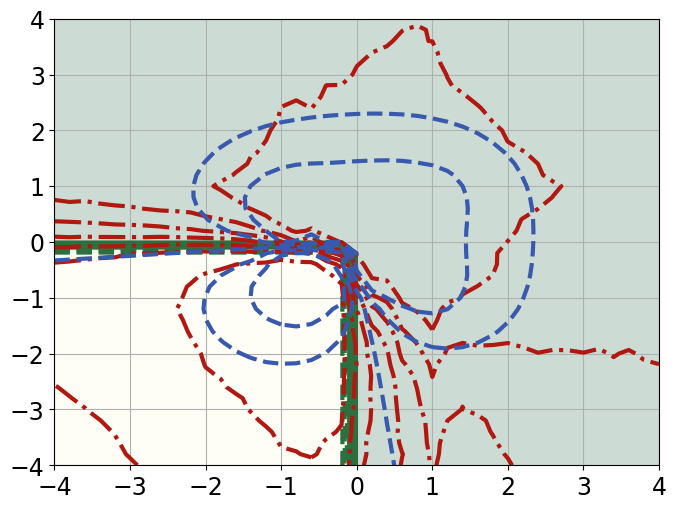

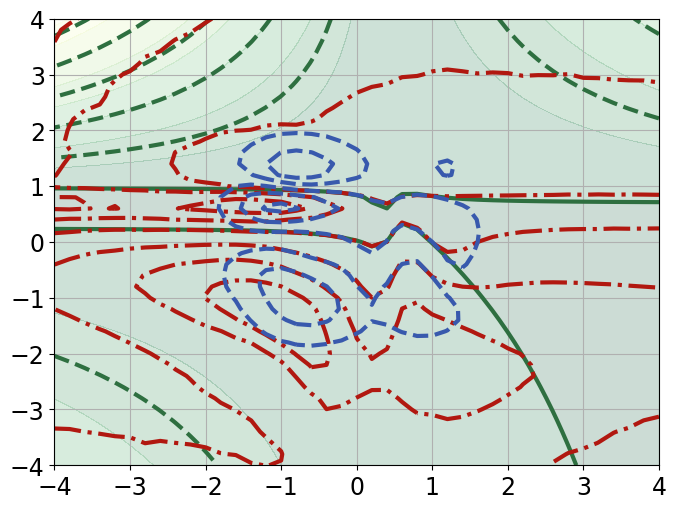

In [ ]:
fname = ["linear", "quadratic", "step", "piecewiselinear"]

for n in [11, 31]:
    for i, f in enumerate([linear, quadratic, step, bilinear_interp]):
        x = np.linspace(-1, 1, n)
        y = np.linspace(-1, 1, n)
        X_train_mesh, Y_train_mesh = np.meshgrid(x, y)
        X_train = np.stack([X_train_mesh.ravel(), Y_train_mesh.ravel()]).T 
        np.random.seed(1)
        X_train = X_train[np.random.choice(n**2, 7*n, replace=False)]
        epsilon = 0.05*np.random.randn(X_train.shape[0])
        y_train = f(X_train) + epsilon
    
        # TabPFN
        regressor = TabPFNRegressor(model_path = "/root/autodl-tmp/pfn/tabpfn-v2-regressor.ckpt")
        regressor.fit(X_train, y_train)
        x = np.linspace(-4, 4, 41)
        y = np.linspace(-4, 4, 41)
        X_test_mesh, Y_test_mesh = np.meshgrid(x, y)
        X_test = np.stack([X_test_mesh.ravel(), Y_test_mesh.ravel()]).T 
        y_pred = regressor.predict(X_test)
         
        # Define multiple kernel candidates
        kernel_candidates = [
            ConstantKernel() * RBF(),
            ConstantKernel() * Matern(nu=1.5),
            ConstantKernel() * RationalQuadratic(),
            ConstantKernel() * ExpSineSquared(),
            ConstantKernel() * RBF() + ConstantKernel() * Matern()
        ]
        alpha_candidates = [0.05, 0.1, 0.15, 0.2]
        
        best_score = -np.inf
        best_gpr = None

        for kernel in kernel_candidates:
            for alpha in alpha_candidates:
                gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha**2, n_restarts_optimizer=10)
                gpr.fit(X_train, y_train)
                score = gpr.log_marginal_likelihood()
                # print(alpha, score)
                
                if score > best_score:
                    best_score = score
                    best_gpr = gpr
                    best_alpha = alpha
        
        y_pred_gp, y_std_gp = gpr.predict(X_test, return_std=True)
        
        fig = plt.figure()
        # True function
        true_contour = plt.contourf(X_test_mesh, Y_test_mesh, f(X_test).reshape(X_test_mesh.shape), levels=10, cmap='YlGn', alpha=0.2)
        true_contour = plt.contour(X_test_mesh, Y_test_mesh, f(X_test).reshape(X_test_mesh.shape), levels=6,  linewidths=3, colors='#2E6F40')
        
        # TabPFN contours
        tabpfn_contour = plt.contour(X_test_mesh, Y_test_mesh, y_pred.reshape(X_test_mesh.shape), levels=6, colors="#b11810", 
                                  linestyles='-.', linewidths=3, label='TabPFN')
        
        # GP contours
        gp_contour = plt.contour(X_test_mesh, Y_test_mesh, y_pred_gp.reshape(X_test_mesh.shape), levels=6, colors="#3859ad", 
                                  linestyles='--', linewidths=3, label='GP')
        plt.grid(True)
        plt.savefig("figure/interpolation_2d_model_" + str(fname[i]) + "_n_" + str(n) + ".png", bbox_inches='tight')